In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from lateral_connections import LateralModel, VggModel, CustomImageDataset

model_path = 'models/VGG19_normalized_avg_pool_pytorch'
vm = VggModel(model_path, torch.device('cuda'), important_layers=['relu1_1', 'pool1', 'pool2'])

model = LateralModel(vgg_model=vm, distance=2, num_output_repetitions=2, horizon_length=64, alpha=0.8)

def torch_transform(img):
    return img.reshape((1,) + img.shape).float()

ds = CustomImageDataset('images/geometric_dataset/annotations.csv', image_transform=torch_transform)


# TODO: Histogram over Time (Input? Output? Kernel?...)
# see https://matplotlib.org/stable/gallery/statistics/hist.html


In [2]:
RUN_WANDB = False

if RUN_WANDB:
    import wandb
    wandb.init(project="MT_LateralConnections", entity="lehl")

pbar = tqdm(range(2048))
for i in pbar:
    img_id = np.random.randint(len(ds))
    img, label = ds[img_id]
    pbar.set_description(f"Processing #{img_id} ({ds.labels[label]})")
    
    model.forward(img)
    
    # Log to WandB
    wandb_dict = dict()
    logging_config = {
        'input': model.A,
        'kernel': model.K,
        'saturation': model.S,
        'horizon': model.H,
        'lateral_activity': model.L,
        'output': model.O
    }
    
    for k in logging_config.keys():
        data = logging_config[k].cpu().detach().numpy()
        
        wandb_dict[k] = {
            'min': np.min(data),
            'max': np.max(data),
            'mean': np.mean(data)
        }
        
        for p in range(0,110,10):
            wandb_dict[k][f"{p}pctl"] = np.percentile(data, p)
    
    if RUN_WANDB:
        #print(wandb_dict)        
        wandb.log(wandb_dict)

  0%|          | 0/2048 [00:00<?, ?it/s]

In [3]:
#model.save_model('models/lateral_models/20220128_2048it_nosoftmax.h5')

Saved model to models/lateral_models/20220128_2048it_nosoftmax.h5 successfully.


In [4]:
#model.load_model('models/lateral_models/20220128_2048it_nosoftmax.h5')

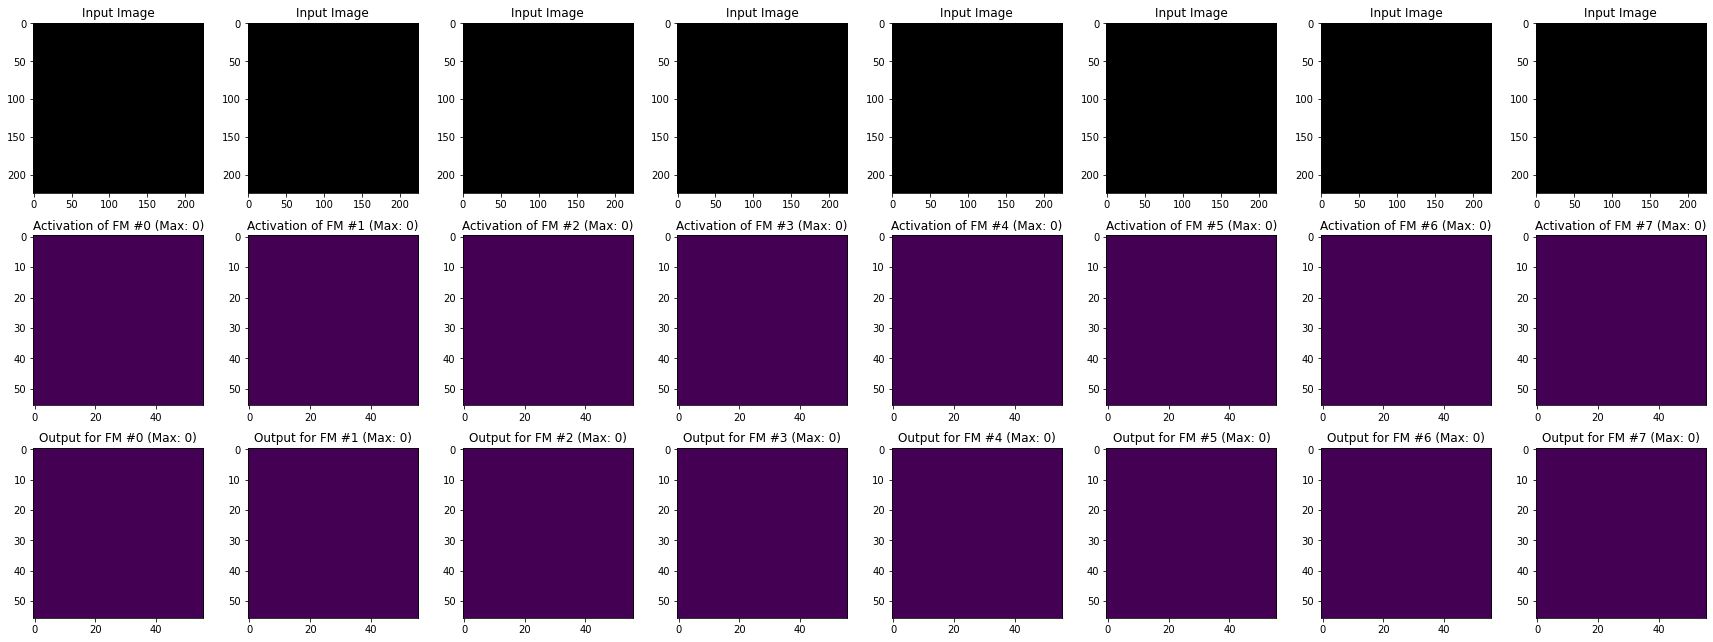

In [11]:
img = torch.Tensor(np.zeros(shape=img.shape)).to(model.gpu_device)
model.forward(img, update=False)

num_fms = 8
plot_scale = 3
fig, axs = plt.subplots(3,num_fms,figsize=(num_fms*plot_scale,3*plot_scale))

for f in range(num_fms):
    data = torch.swapaxes(torch.swapaxes(img[0,...], 0, 2), 0, 1).cpu().numpy().astype(int)
    axs[0, f].imshow(data, vmin=0, vmax=1)
    axs[0, f].set_title(f"Input Image")
    
    data = model.A[f,:,:].cpu().detach().numpy()
    axs[1,f].imshow(data)
    axs[1,f].set_title(f"Activation of FM #{f} (Max: {int(np.max(data))})")
    
    data = model.O[f,:,:].cpu().detach().numpy()
    axs[2,f].imshow(data)
    axs[2,f].set_title(f"Output for FM #{f} (Max: {int(np.max(data))})")

plt.tight_layout()

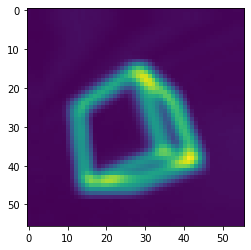

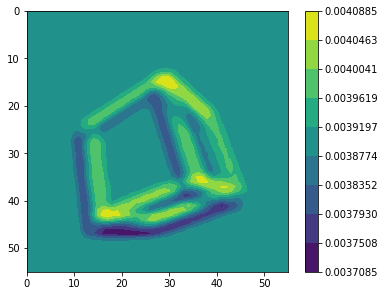

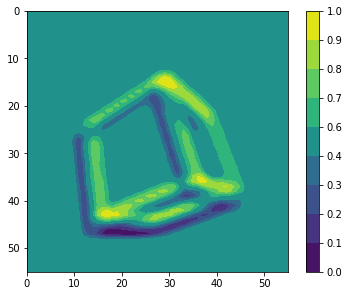

In [16]:
import torch
import torch.nn.functional as F

data_softmax = torch.nn.Softmax2d()(model.L.unsqueeze(0))
figure_data = data_softmax[0,0,:,:].cpu().detach().numpy()

# Before Softmax Plot
fig = plt.figure()
plt.imshow(model.L[0,...].cpu().detach().numpy())
plt.show()

# After Softmax Plot
fig, ax = plt.subplots(constrained_layout=True)
levels = np.linspace(np.min(figure_data), np.max(figure_data), 10)

if np.unique(levels).shape == levels.shape:
    cs = ax.contourf(figure_data, levels)
    fig.colorbar(cs)
ax.set_aspect('equal','box')

plt.gca().invert_yaxis()
plt.show()

# MinMax Scaled

scaled_figure_data = (figure_data - np.min(figure_data)) / (np.max(figure_data) - np.min(figure_data))
fig, ax = plt.subplots(constrained_layout=True)
levels = np.round(np.linspace(np.min(scaled_figure_data), np.max(scaled_figure_data), 10),1)

if np.unique(levels).shape == levels.shape:
    cs = ax.contourf(scaled_figure_data, levels)
    fig.colorbar(cs)
ax.set_aspect('equal','box')

plt.gca().invert_yaxis()
plt.show()


None

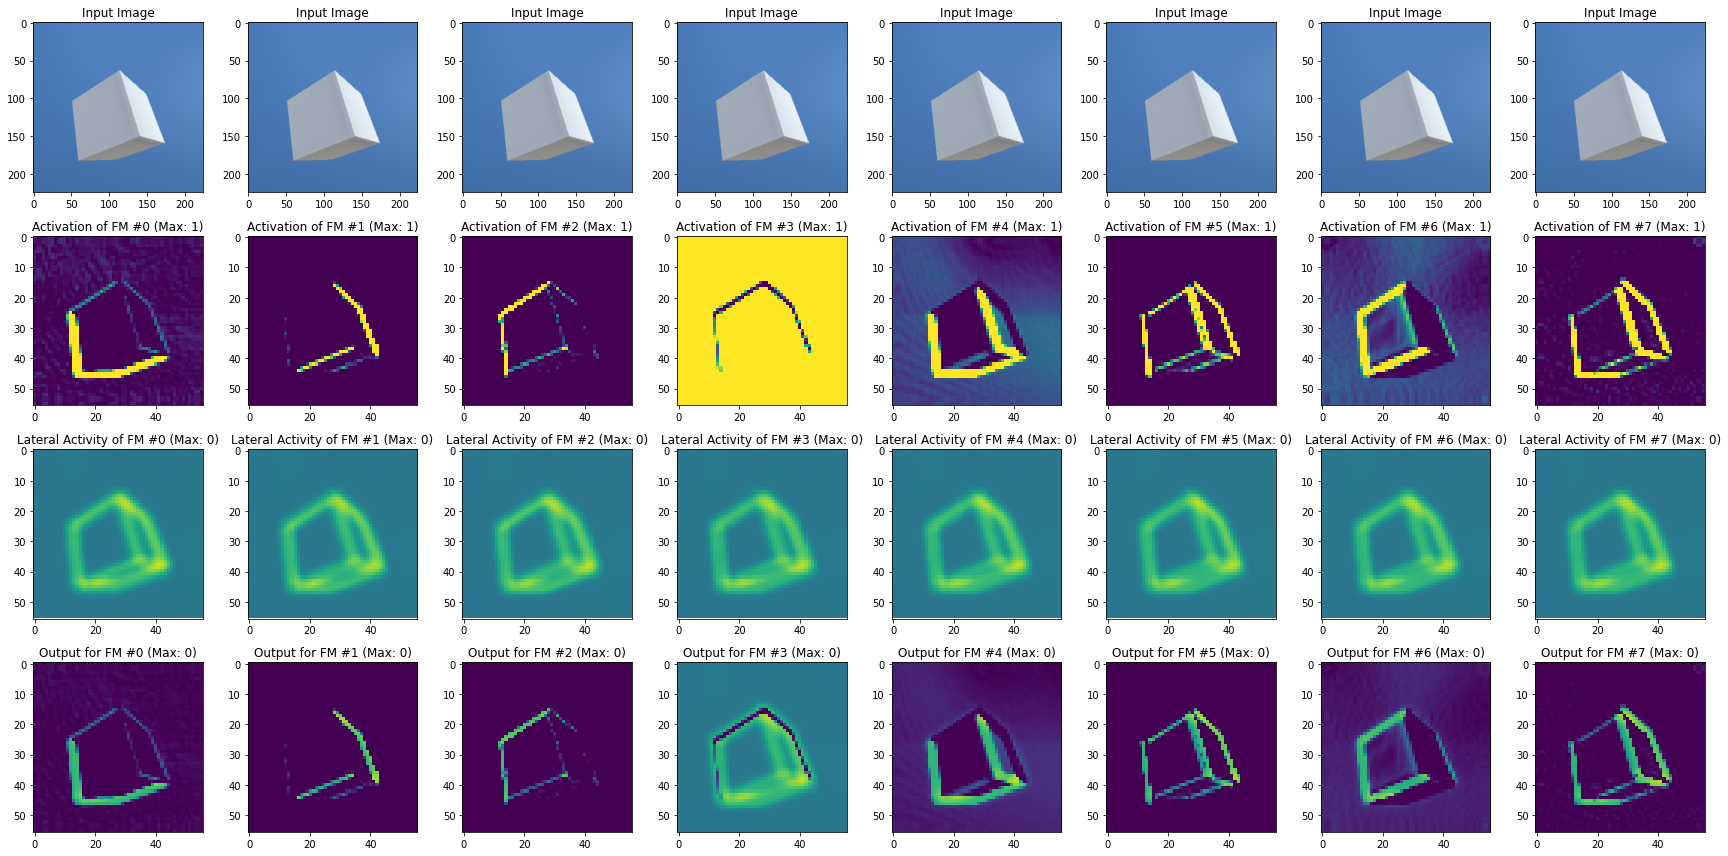

In [15]:
img,_ = ds[np.random.randint(len(ds))]
img,_ = ds[1400]
model.forward(img, update=False)

num_fms = 8
plot_scale = 3

fig, axs = plt.subplots(4,num_fms,figsize=(num_fms*plot_scale, 4*plot_scale))

for f in range(num_fms):
    data0 = torch.swapaxes(torch.swapaxes(img[0,...], 0, 2), 0, 1).cpu().numpy().astype(int)
    axs[0, f].imshow(data0, vmin=0, vmax=1)
    axs[0, f].set_title(f"Input Image")
    
    data1 = model.A[f,:,:].cpu().detach().numpy()
    axs[1,f].imshow(data1, vmin=0, vmax=1)
    axs[1,f].set_title(f"Activation of FM #{f} (Max: {int(np.max(data1))})")
    
    data2 = model.L[f,:,:].cpu().detach().numpy()
    axs[2,f].imshow(data2, vmin=0, vmax=1)
    axs[2,f].set_title(f"Lateral Activity of FM #{f} (Max: {int(np.max(data2))})")
    
    data3 = model.O[f,:,:].cpu().detach().numpy()
    axs[3,f].imshow(data3, vmin=0, vmax=1)
    axs[3,f].set_title(f"Output for FM #{f} (Max: {int(np.max(data3))})")

plt.tight_layout()

torch.Size([256, 56, 56])
torch.Size([256, 60, 60])
225


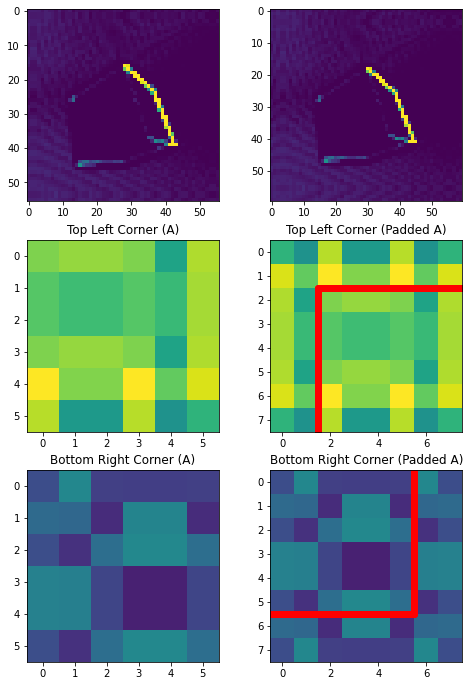

In [18]:
print(model.A.shape)
print(model.padded_A.shape)

fm_i=225
print(fm_i)

fig, axs = plt.subplots(3,2, figsize=(8,12))
axs[0,0].imshow(model.A[fm_i,:,:].cpu(),vmin=0,vmax=1)
axs[0,1].imshow(model.padded_A[fm_i,:,:].cpu(),vmin=0,vmax=1)
#--------------------------------------------------------------------------
# Top Left Corner
axs[1,0].imshow(model.A[fm_i,:6,:6].cpu(), vmin=0, vmax=0.1)
axs[1,1].imshow(model.padded_A[fm_i,:8,:8].cpu(), vmin=0, vmax=0.1)
axs[1,0].set_title('Top Left Corner (A)')
axs[1,1].set_title('Top Left Corner (Padded A)')
x = np.linspace(1.5,7.5,100)
y = np.ones(shape=x.shape) * 1.5
axs[1,1].scatter(x,y,color='r',linewidth=1)
axs[1,1].scatter(y,x,color='r',linewidth=1)
#--------------------------------------------------------------------------
# Bottom Right Corner
axs[2,0].imshow(model.A[fm_i,-6:,-6:].cpu(), vmin=0, vmax=0.1)
axs[2,1].imshow(model.padded_A[fm_i,-8:,-8:].cpu(), vmin=0, vmax=0.1)
axs[2,0].set_title('Bottom Right Corner (A)')
axs[2,1].set_title('Bottom Right Corner (Padded A)')
x = np.linspace(-0.5,5.5,100)
y = np.ones(shape=x.shape) * 5.5
axs[2,1].scatter(x,y,color='r',linewidth=1)
axs[2,1].scatter(y,x,color='r',linewidth=1)

tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
---
tensor(True, device='cuda:0')


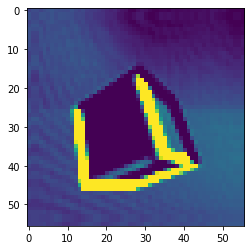

In [75]:
A3 = torch.clone(model.A)

A3[...,:2,:] = torch.flip(A3[...,2:4,:], dims=(-2,))
A3[...,-2:,:] = torch.flip(A3[...,-4:-2,:], dims=(-2,))
A3[...,:,:2] = torch.flip(A3[...,:,2:4], dims=(-1,))
A3[...,:,-2:] = torch.flip(A3[...,:,-4:-2], dims=(-1,))

print((A2[:,:2,:] == A3[:,:2,:]).all())
print((A2[:,-2:,:] == A3[:,-2:,:]).all())
print((A2[:,:,:2] == A3[:,:,:2]).all())
print((A2[:,:,-2:] == A3[:,:,-2:]).all())

plt.imshow(A3.cpu().detach().numpy()[4,:,:])
print('---')
print((A3 == A2).all())

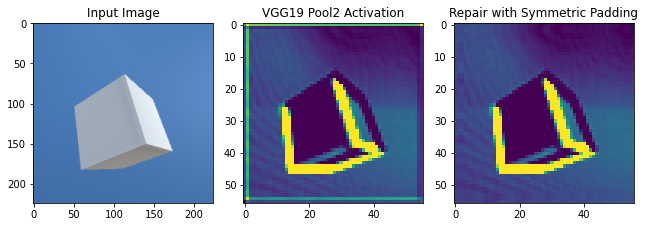

In [80]:
num_kernels_to_plot = 3
plot_scale = 3
fig, axs = plt.subplots(1, num_kernels_to_plot, figsize=(plot_scale*num_kernels_to_plot, 4))

axs[0].imshow(plottable_image(img))
axs[0].set_title(f"Input Image")

axs[1].imshow(model.A.cpu()[4,:,:])
axs[1].set_title(f"VGG19 Pool2 Activation")

axs[2].imshow(A3.cpu()[4,:,:])
axs[2].set_title(f"Repair with Symmetric Padding")

plt.tight_layout()

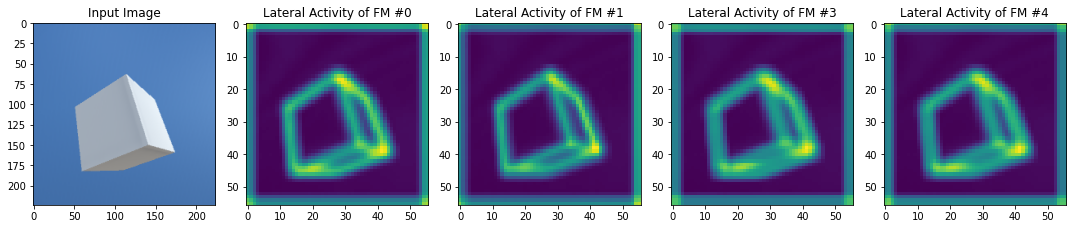

In [27]:
num_kernels_to_plot = 5
plot_scale = 3
fig, axs = plt.subplots(1, num_kernels_to_plot, figsize=(plot_scale*num_kernels_to_plot, 4))

axs[0].imshow(plottable_image(img))
axs[0].set_title(f"Input Image")

for i, ix in enumerate([0, 1, 3, 4]):
        data = model.L.cpu().detach().numpy()[ix,:,:]
        #axs[i].imshow(data, vmin=-1, vmax=1)
        axs[i+1].imshow(data, vmax=np.max(data))
        axs[i+1].set_title(f"Lateral Activity of FM #{ix}")
plt.tight_layout()

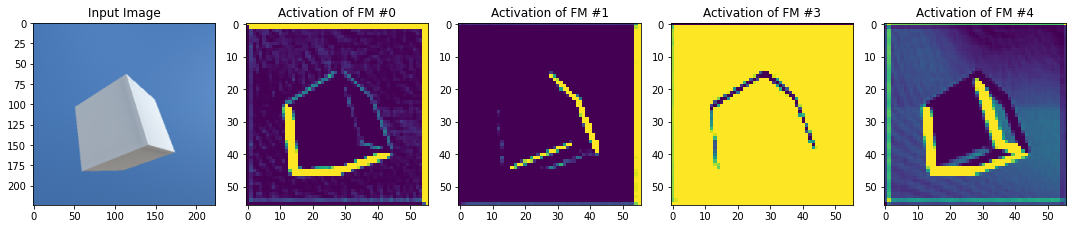

In [25]:
num_kernels_to_plot = 5
plot_scale = 3
fig, axs = plt.subplots(1, num_kernels_to_plot, figsize=(plot_scale*num_kernels_to_plot, 4))

axs[0].imshow(plottable_image(img))
axs[0].set_title(f"Input Image")

for i, ix in enumerate([0, 1, 3, 4]):
        data = model.A.cpu().detach().numpy()[ix,:,:]
        #axs[i].imshow(data, vmin=-1, vmax=1)
        axs[i+1].imshow(data, vmax=np.max(data))
        axs[i+1].set_title(f"Activation of FM #{ix}")
plt.tight_layout()

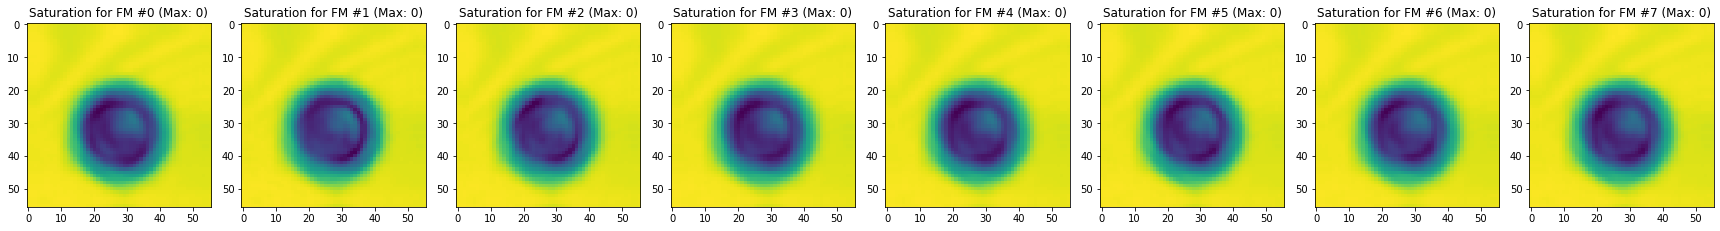

In [19]:
num_kernels_to_plot = 8
plot_scale = 3
fig, axs = plt.subplots(1, num_kernels_to_plot, figsize=(plot_scale*num_kernels_to_plot, 4))

for i in range(num_kernels_to_plot):
        data = model.S.cpu().detach().numpy()[i,:,:]
        #axs[i].imshow(data, vmin=-1, vmax=1)
        axs[i].imshow(data, vmax=np.max(data))
        axs[i].set_title(f"Saturation for FM #{i} (Max: {int(np.max(data))})")
plt.tight_layout()

(256, 256, 5, 5)


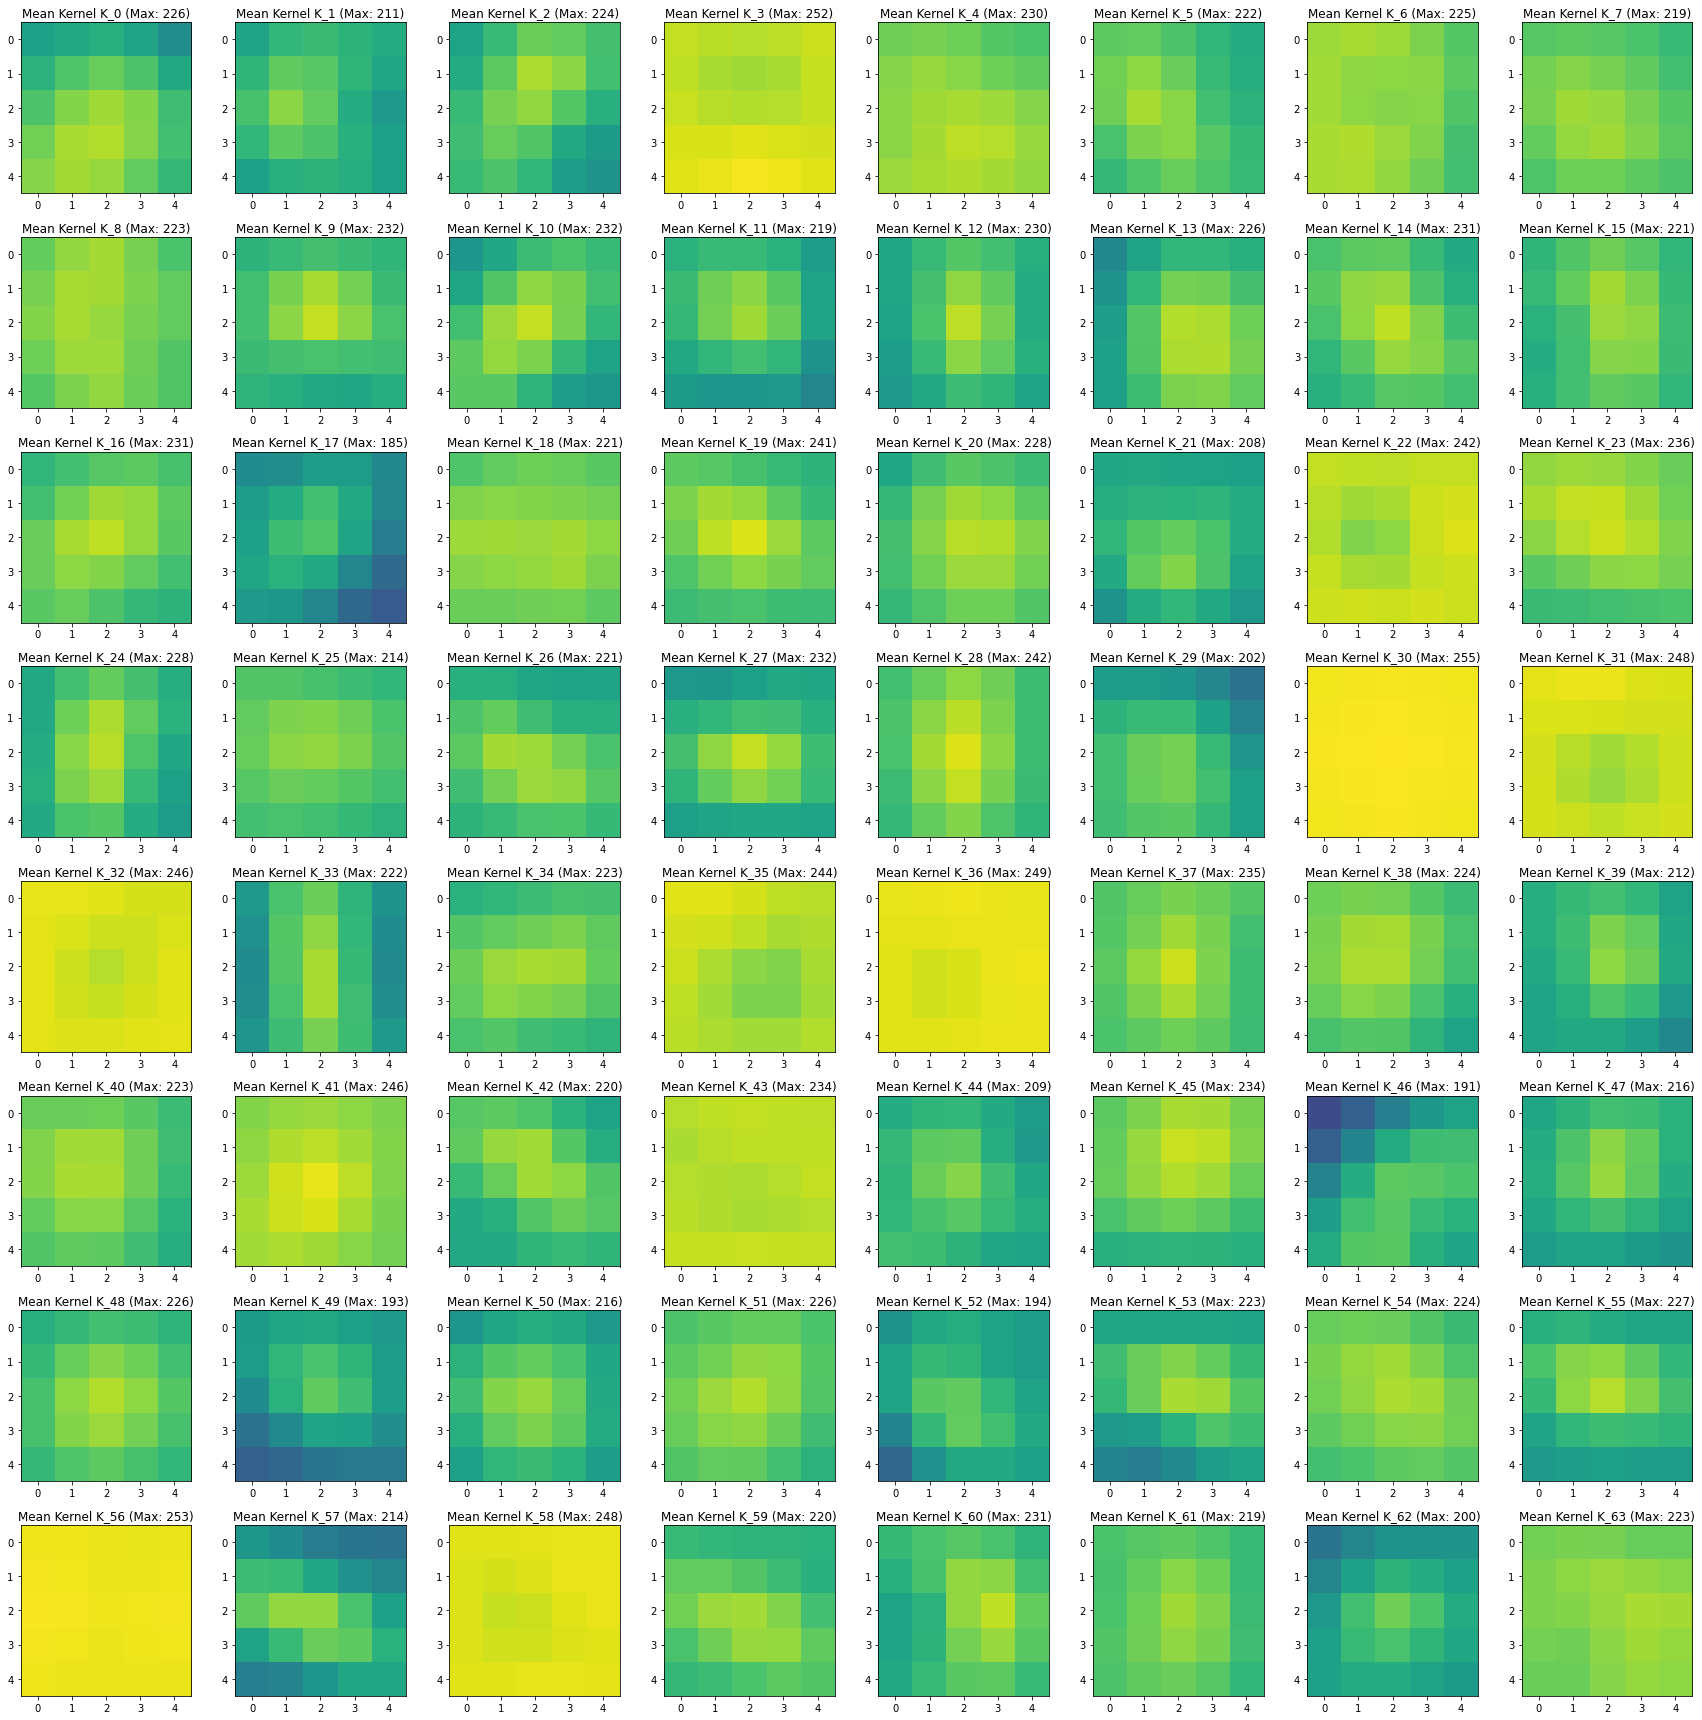

In [20]:
data = model.K.cpu().detach().numpy()
print(data.shape)

max_kernels = np.max(data, axis=(2,3))[..., np.newaxis, np.newaxis]
max_kernels[max_kernels==0] = 1.0
scaled_kernels = np.sum(data / max_kernels, axis=1)

num_kernels_to_plot = 8
plot_scale = 3
fig, axs = plt.subplots(num_kernels_to_plot, num_kernels_to_plot, figsize=(plot_scale*num_kernels_to_plot, plot_scale*num_kernels_to_plot))

for i in range(num_kernels_to_plot):
    for j in range(num_kernels_to_plot):
        data = scaled_kernels[j+num_kernels_to_plot*i,:,:]
        axs[i,j].imshow(data, vmin=0, vmax=model.K.shape[0])
        axs[i,j].set_title(f"Mean Kernel K_{j+num_kernels_to_plot*i} (Max: {int(np.max(data))})")
plt.tight_layout()

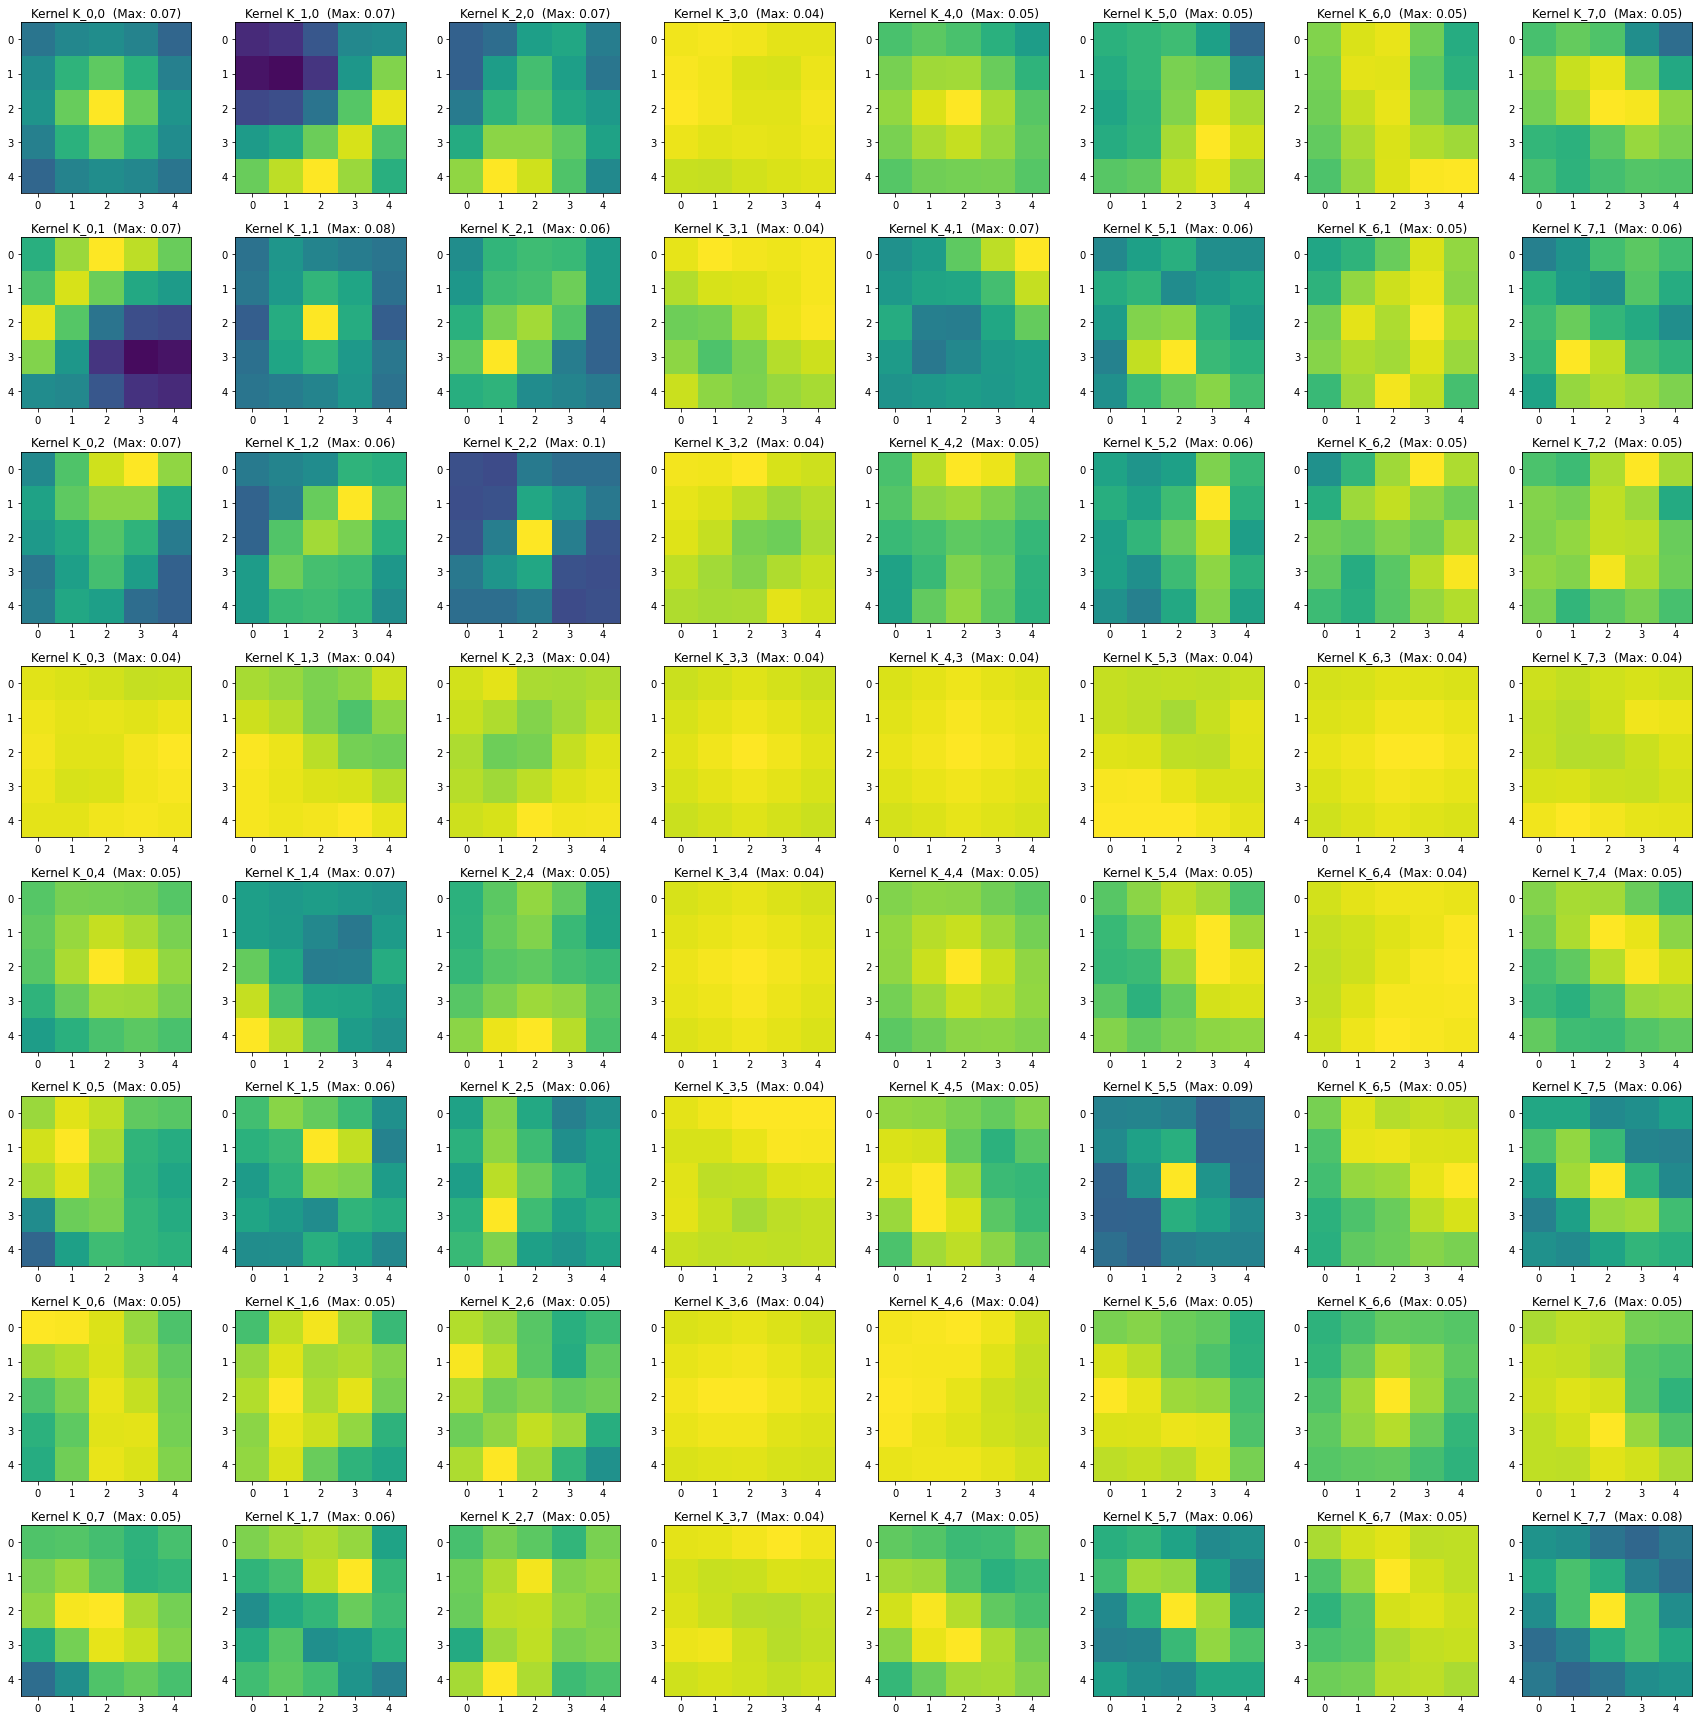

In [24]:
num_input_feature_maps = 8
num_output_feature_maps = 8
plot_scale = 3

fig, axs = plt.subplots(num_output_feature_maps, num_input_feature_maps, figsize=(plot_scale*num_output_feature_maps,plot_scale*num_input_feature_maps))

for i in range(num_output_feature_maps):
    for j in range(num_input_feature_maps):
        data = model.K[i, j, :, :].cpu().detach().numpy()
        #axs[i,j].imshow(data, vmin=0, vmax=0.1)
        axs[i,j].imshow(data, vmin=0, vmax=np.max(data))
        axs[i,j].set_title(f"Kernel K_{j},{i}  (Max: {round(float(np.max(data)), 2)})")
plt.tight_layout()

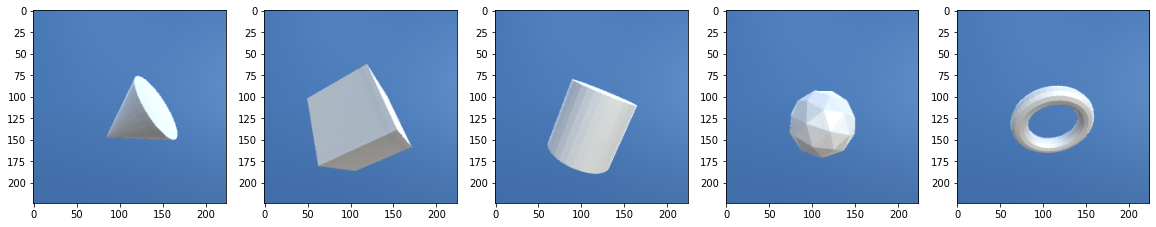

In [22]:
def plottable_image(img):
    return torch.swapaxes(torch.swapaxes(img[0,...], 0, 2), 0, 1).numpy().astype(int)

j = 500

num_objects = 5
fig, axs = plt.subplots(1, num_objects, figsize=(4*num_objects, 4))

for i in range(num_objects):
    idx = i*1024 + j
    
    img, _ = ds[idx]
    axs[i].imshow(plottable_image(img))
    
    

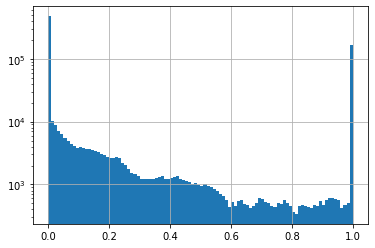

In [28]:
"""
vals, bins = np.histogram(model.A.cpu().detach().numpy(), bins=100)

print(vals)
print(bins)
"""
data = model.A.cpu().detach().numpy().reshape(-1)
plt.hist(data, bins=100)
plt.yscale('log')
plt.grid()
plt.show()



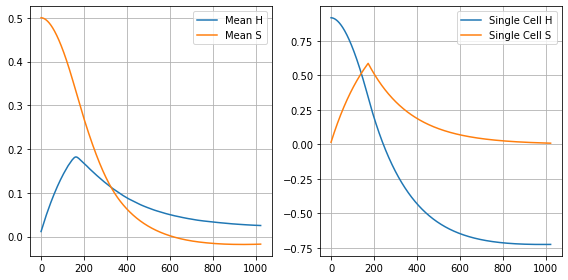

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
axs[0].plot(mean_h, label='Mean H')
axs[0].plot(mean_s, label='Mean S')
axs[0].grid(True)
axs[0].legend()
axs[1].plot(last_h, label='Single Cell H')
axs[1].plot(last_s, label='Single Cell S')
axs[1].grid(True)
axs[1].legend()
plt.tight_layout()

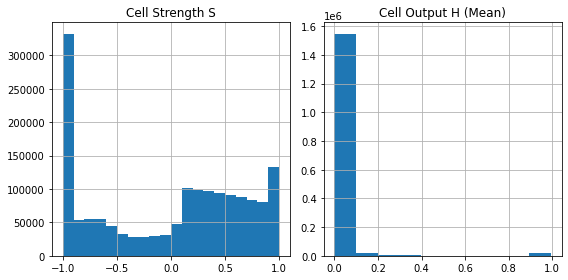

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
axs[0].hist(model.S.cpu().detach().numpy().reshape(np.prod(model.S.shape)), bins=20)
#axs[0].set_yscale('log')
axs[0].grid(True)
axs[0].set_title('Cell Strength S')
axs[1].hist(model.H.cpu().detach().numpy().reshape(np.prod(model.H.shape)), bins=10)
#axs[1].set_yscale('log')
axs[1].grid(True)
axs[1].set_title('Cell Output H (Mean)')
plt.tight_layout()

In [52]:
model.G_d.shape

torch.Size([128, 56, 56])

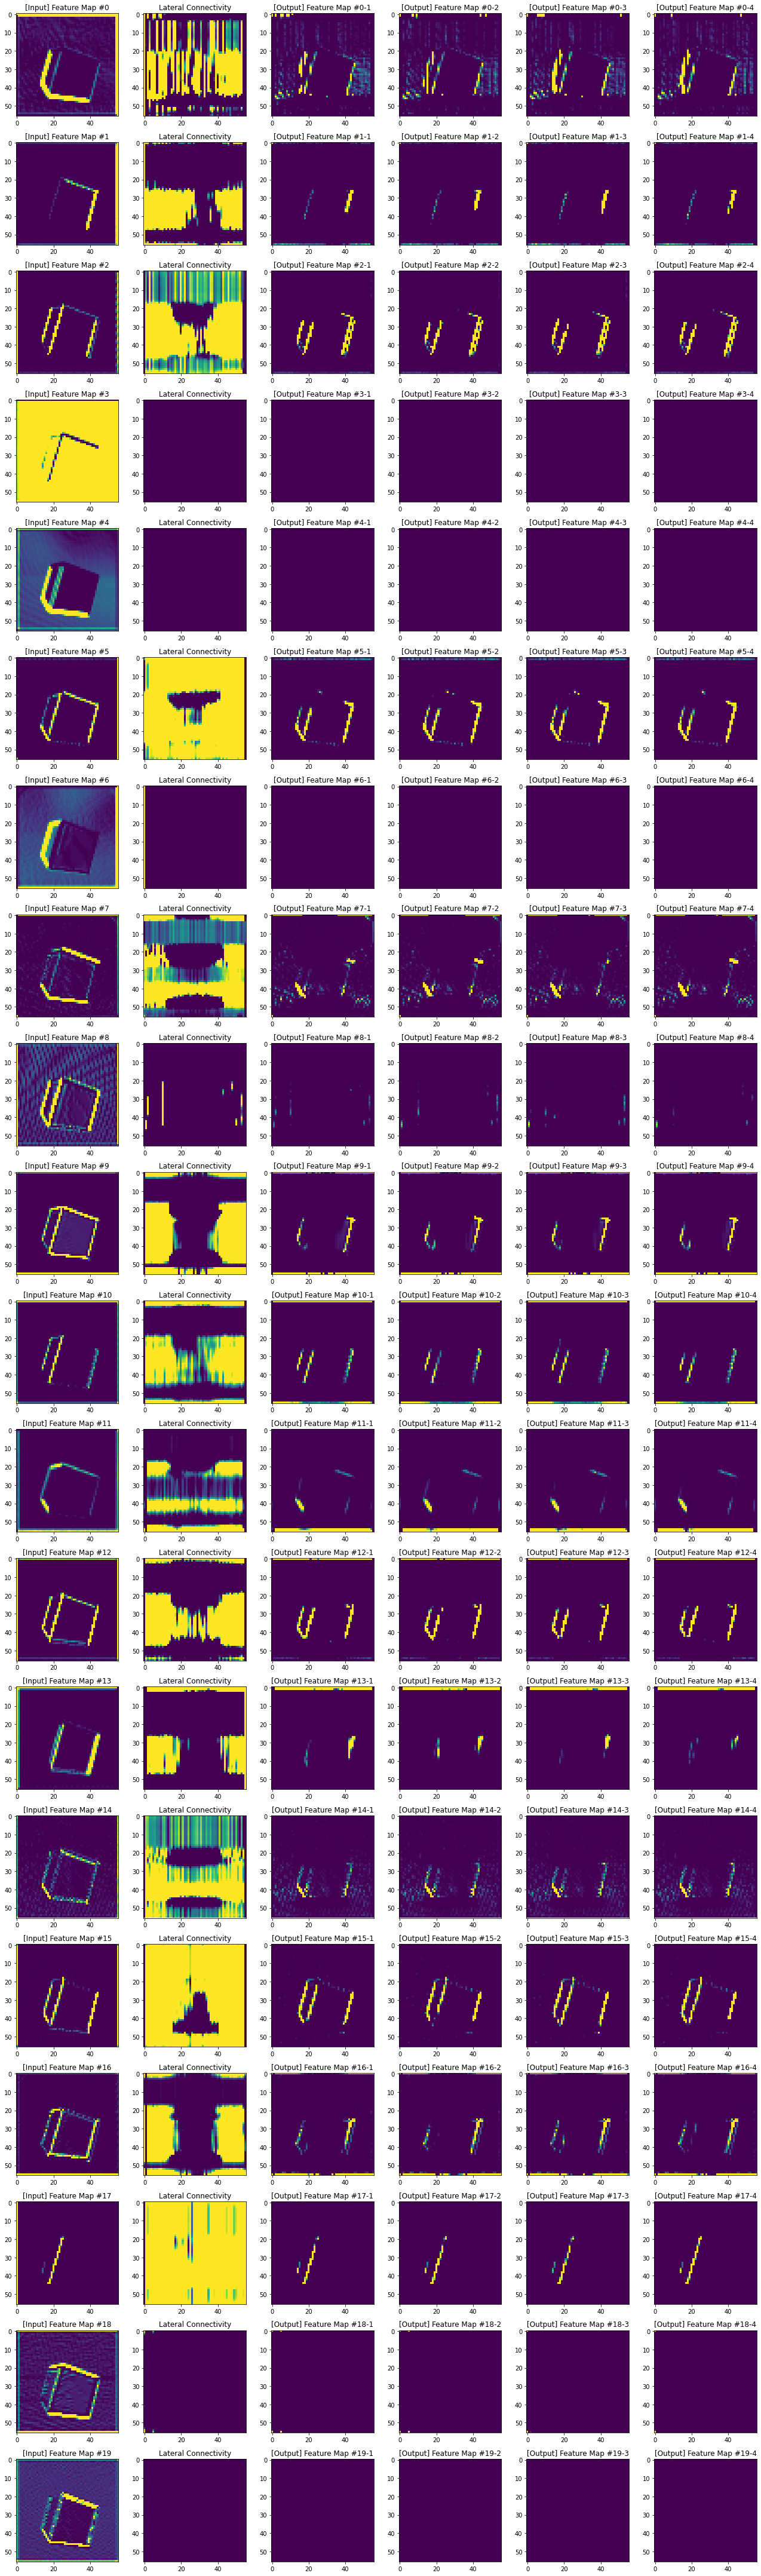

In [51]:
num_fm = 20
plot_size = 3

#feature_map_idx = np.sort(np.random.choice(model.O.shape[-3], num_fm, replace=False))
feature_map_idx = np.arange(num_fm)

fig, axs = plt.subplots(num_fm, 2 + model.num_output_repetitions, figsize=(plot_size*(2 + model.num_output_repetitions), plot_size*num_fm))
for i, fm_i in enumerate(feature_map_idx):
    axs[i][0].imshow(model.C[0, fm_i, :, :].cpu().detach().numpy(), vmin=0, vmax=1)
    axs[i][0].set_title(f"[Input] Feature Map #{fm_i}")
    
    axs[i][1].imshow(model.L[0, fm_i, :, :].cpu().detach().numpy(), vmin=0, vmax=1)
    axs[i][1].set_title(f"Lateral Connectivity")
    
    for n in range(model.num_output_repetitions):
        axs[i][2+n].imshow(model.O[n, fm_i, :, :].cpu().detach().numpy(), vmin=0, vmax=1)
        axs[i][2+n].set_title(f"[Output] Feature Map #{fm_i}-{n+1}")
    
plt.tight_layout()
